In [1]:
!pip install segmentation-models-3D

  Using cached segmentation_models_3D-1.0.4-py3-none-any.whl (33 kB)
  Obtaining dependency information for tensorflow>=2.8.0 from https://files.pythonhosted.org/packages/81/16/3aaaf911d8309b9afb29bff97e819c52b011d4ab184c7b01cec92abd018a/tensorflow-2.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached classification_models_3D-1.0.7-py3-none-any.whl (69 kB)
  Obtaining dependency information for numpy>=1.9.1 from https://files.pythonhosted.org/packages/75/cd/7ae0f2cd3fc68aea6cfb2b7e523842e1fa953adb38efabc110d27ba6e423/numpy-1.26.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.9 MB/s eta 0:00:00
  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/4f/79/8e6e05bc4954ebdb8b9c587f780a11f28790585798bd15a8e4870cfc02bc/h5py-3.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64

In [ ]:
#----MODEL TRAINING CODE----

# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


if __name__ == '__main__':
    import os

    gpu_use = 0
    print('GPU use: {}'.format(gpu_use))
    os.environ["KERAS_BACKEND"] = "tensorflow"
    os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(gpu_use)


import segmentation_models_3D as sm
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import measure
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras import backend as K


def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model' or layer_type == 'Functional':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes


def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

def cylinder(shape, radius, height):
    """Generate a 3D cylindrical mask."""
    assert len(shape) == 3
    x_dim, y_dim, z_dim = shape
    x_center, y_center = x_dim // 2, y_dim // 2  # Center of the cylinder in x and y dimensions

    # Create a grid of coordinates
    x, y, z = np.ogrid[:x_dim, :y_dim, :z_dim]

    # Calculate the distance from the center of the cylinder in the x-y plane
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # Create the cylindrical mask
    cylinder_mask = (distance_from_center <= radius) & (z >= 0) & (z <= height)

    return cylinder_mask

def gen_random_volume(debug=False):
    img = np.zeros((96, 96, 96, 3), dtype=np.uint8)
    mask = np.zeros((96, 96, 96, 2), dtype=np.uint8)
    num_sheres = random.randint(2, 4)
    min_radius = 3
    max_radius = 20
    num_cubes = random.randint(2, 4)
    min_cube_side = 3
    max_cube_side = 15
    num_cylinders = random.randint(2, 4)
    # Background
    dark_color0 = random.randint(0, 100)
    dark_color1 = random.randint(0, 100)
    dark_color2 = random.randint(0, 100)
    img[..., 0] = dark_color0
    img[..., 1] = dark_color1
    img[..., 2] = dark_color2

    #NEW
    objectMasks = []

    # Spheres
    for i in range(num_sheres):
        light_color0 = random.randint(dark_color0+1, 255)
        light_color1 = random.randint(dark_color1+1, 255)
        light_color2 = random.randint(dark_color2+1, 255)
        center_0 = random.randint(0, img.shape[0] - 1)
        center_1 = random.randint(0, img.shape[1] - 1)
        center_2 = random.randint(0, img.shape[2] - 1)
        r1 = random.randint(min_radius, max_radius)
        # print(r1, (center_0, center_1, center_2), (light_color0, light_color1, light_color2))
        s = sphere(img.shape[:-1], r1, (center_0, center_1, center_2))
        tmp = img.copy()
        tmp[s] = (light_color0, light_color1, light_color2)
        img[s] = tmp[s]
        mask[s] = (255, 0)

        #NEW
        objectMasks.append(s)

        # print(img.min(), img.max(), img.mean(), img.dtype)

    # Cubes
    for i in range(num_cubes):
        light_color0 = random.randint(dark_color0 + 1, 255)
        light_color1 = random.randint(dark_color1 + 1, 255)
        light_color2 = random.randint(dark_color2 + 1, 255)
        range0_start = random.randint(0, img.shape[0] - max_cube_side)
        range0_end = range0_start + random.randint(min_cube_side, max_cube_side)
        range1_start = random.randint(0, img.shape[1] - max_cube_side)
        range1_end = range1_start + random.randint(min_cube_side, max_cube_side)
        range2_start = random.randint(0, img.shape[2] - max_cube_side)
        range2_end = range2_start + random.randint(min_cube_side, max_cube_side)
        img[range0_start:range0_end, range1_start:range1_end, range2_start:range2_end] = (light_color0, light_color1, light_color2)
        mask[range0_start:range0_end, range1_start:range1_end, range2_start:range2_end] = (0, 255)

        #NEW
        currMask = (np.zeros((96, 96, 96), dtype=np.uint8) != 0)
        currMask[range0_start:range0_end, range1_start:range1_end, range2_start:range2_end] = True
        objectMasks.append(currMask)


    for i in range(num_cylinders):
        light_color0 = random.randint(dark_color0 + 1, 255)
        light_color1 = random.randint(dark_color1 + 1, 255)
        light_color2 = random.randint(dark_color2 + 1, 255)
    # Debug
    if debug:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

        verts, faces, normals, values = measure.marching_cubes(img[..., 1], 127)
        ax.plot_trisurf(
            verts[:, 0],
            verts[:, 1],
            faces,
            verts[:, 2],
            cmap='Spectral',
            antialiased=False,
            linewidth=0.0
        )
        plt.show()

    # White noise
    density = random.uniform(0, 0.1)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                if random.random() < density:
                    img[i, j, k] = (
                        random.randint(0, 255),
                        random.randint(0, 255),
                        random.randint(0, 255),
                    )

    return img, mask, objectMasks


def batch_generator(batch_size, preprocess_input):
    while True:
        image_list = []
        mask_list = []
        objectMasks_list = []
        for i in range(batch_size):
            img, mask, objectMasks = gen_random_volume()
            image_list.append(img)
            mask_list.append(mask)
            objectMasks_list.append(objectMasks)

        image_list = np.array(image_list, dtype=np.float32)
        image_list = preprocess_input(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        mask_list /= 255.0
        # print(image_list.shape, mask_list.shape)
        yield image_list, mask_list, np.array(objectMasks_list)


def train_model_example():
    encoder_weights = 'imagenet'
    shape_size = (96, 96, 96, 3)
    backbone = 'resnet18'
    num_classes = 2
    batch_size_train = 6
    batch_size_valid = 6
    learning_rate = 0.0001
    patience = 10
    epochs = 1
    steps_per_epoch = 100
    validation_steps = 20

    model = sm.Unet(
        backbone,
        input_shape=shape_size,
        encoder_weights=encoder_weights,
        classes=num_classes,
    )
    # print(model.summary())
    print(get_model_memory_usage(batch_size_train, model))
    preprocess_input = sm.get_preprocessing(backbone)
    optim = Adam(learning_rate=learning_rate)

    loss_to_use = sm.losses.bce_jaccard_loss
    model.compile(optimizer=optim, loss=loss_to_use, metrics=[sm.metrics.iou_score, sm.metrics.f1_score])

    cache_model_path = '{}_temp.h5'.format(backbone)
#     best_model_path = '{}'.format(backbone) + '-{val_iou_score:.4f}-{epoch:02d}.h5'
    best_model_path = '{}'.format(backbone) + '.h5'


    callbacks = [
        ModelCheckpoint(cache_model_path, monitor='val_loss', verbose=0),
        ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0),
        ReduceLROnPlateau(monitor='val_iou_score', factor=0.95, patience=3, min_lr=1e-9, min_delta=1e-8, verbose=1, mode='max'),
        CSVLogger('history_{}_lr_{}.csv'.format(backbone, learning_rate), append=True),
        EarlyStopping(monitor='val_iou_score', patience=patience, verbose=0, mode='max'),
    ]

    gen_train = batch_generator(
        batch_size_train,
        preprocess_input
    )
    gen_valid = batch_generator(
        batch_size_valid,
        preprocess_input,
    )
    history = model.fit(
        gen_train,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=gen_valid,
        validation_steps=validation_steps,
        verbose=1,
        max_queue_size=10,
        initial_epoch=0,
        callbacks=callbacks
    )

    max_iou = max(history.history['val_iou_score'])
    print('Training finished. Max IoU: {}'.format(max_iou))
    return model


# Uncomment the below code to train the model. Make sure the # of epochs are set correctly!

# myVar = None
# if __name__ == '__main__':
    # gen_random_volume(debug=True)
    # myVar = train_model_example()
# print("COMPLETED MODEL: ", myVar)


GPU use: 0
Segmentation Models: using `tf.keras` framework.


In [ ]:
#----PRINT SECOND TO LAST LAYER IN SEGMENTATION MODEL----
import tensorflow as tf
import segmentation_models_3D as sm
#Load best model
myVar = tf.keras.models.load_model('/content/drive/MyDrive/resnet18-0.0362-01.h5', custom_objects={'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss, 'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.f1_score})
layer = myVar.get_layer("final_conv")
print("Layer Name:", layer.name)
print("Layer Type:", type(layer).__name__)
print("Layer Configuration:", layer.get_config())
print("Layer Output Shape:", layer.output_shape)
print("--------------------------------------------")
print()

Layer Name: final_conv
Layer Type: Conv3D
Layer Configuration: {'name': 'final_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2, 'kernel_size': (3, 3, 3), 'strides': (1, 1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer Output Shape: (None, 96, 96, 96, 2)
--------------------------------------------



In [ ]:
#----Create new model without sigmoid from last layer, and predict an example scene with the new and original model----

print(myVar.layers[-2].output)
print(myVar.input)
newModel = tf.keras.models.Model(inputs = myVar.input, outputs = myVar.layers[-2].output)
loss_to_use = sm.losses.bce_jaccard_loss

optim = Adam(learning_rate=0.0001)
newModel.compile(optimizer=optim, loss=loss_to_use, metrics=[sm.metrics.iou_score, sm.metrics.f1_score])

backbone = 'resnet18'
preprocess_input = sm.get_preprocessing(backbone)
gen_train = batch_generator(
        1,
        preprocess_input
    )
print(gen_train)
thing = next(gen_train)
objectMasks = thing[2]
maskTruth = thing[1]
prediction1 = newModel.predict(thing[0])[0]
prediction2 = myVar.predict(thing[0])[0]
#The predictions are


KerasTensor(type_spec=TensorSpec(shape=(None, 96, 96, 96, 2), dtype=tf.float32, name=None), name='final_conv/BiasAdd:0', description="created by layer 'final_conv'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 96, 96, 3), dtype=tf.float32, name='data'), name='data', description="created by layer 'data'")
<generator object batch_generator at 0x7e9ac596d1c0>
1/1 [==============================] - 6s 6s/step


In [ ]:
#instead of putting the mask on, in a real scenario we don't just have the perfect mask, we want to get it.
#so we have to get the number of objects by doing bfs on the prediction2 array (ignoring blank space).
#start bfs on a single pixel in the array. keep going until you encounter pixels with different predicted values.
#That way you only visit adjacent pixels of the same value (this means they are on the same object).
#if you find a pixel you visited before, just return.
#Do this process for every single pixel. that way, we can count the number of adjacent pixels with the same value,
#and if the number is above 25 or so, we can call that a full object.
from collections import deque
predShape = np.array(prediction2.shape[:-1])
def inBounds(coord, shape1):
  return np.all(shape1 > coord) and np.all(np.array([0,0,0]) <= coord)
def pixelPred(value):
  return 1 * (max(value) == value)



def getMasksBFS(predictarr):
  masks = []
  adj = np.array([(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)])
  visited = set()
  objPts = []
  first = ()
  bfsQ = deque()
  for i in range(len(predictarr)):
    for j in range(len(predictarr[0])):
      for k in range(len(predictarr[0][0])):
        if (i,j,k) in visited or list(predictarr[(i,j,k)]) == [0,0]:
          continue
        visited.add((i,j,k))
        first = (predictarr[(i,j,k)])
        bfsQ.appendleft(np.array((i,j,k)))
        while bfsQ:
          curr = bfsQ.pop()
          objPts.append(curr)
          for offset in adj:
            adjCoord = curr + np.array(offset)
            if inBounds(adjCoord, predShape) and not (tuple(adjCoord) in visited) and list(first) == list(predictarr[tuple(curr)]):
              visited.add(tuple(adjCoord))
              bfsQ.appendleft(adjCoord)
        if len(objPts) > 25:
          objPts = np.array(objPts)
          print("OBJECT FOUND. NUM PTS: ", len(objPts))
          currMask = np.zeros_like(predictarr)
          currMask[objPts[:, 0], objPts[:, 1], objPts[:, 2]] = first
          masks.append(currMask)
        objPts = []
  return masks

#make all elements corresponding to empty spaces in prediction2 [0,0]. This signifies that the pixel is not for a cube nor a sphere.

pixelClassifications = np.apply_along_axis(pixelPred, 3, prediction2)


truthMask = np.all(maskTruth[0] == [0,0], axis = 3)
finalPred = np.copy(pixelClassifications)
finalPred[truthMask] = [0,0]

# print("FINALPRED:", finalPred)
allMasks = getMasksBFS(finalPred)


OBJECT FOUND. NUM PTS:  19782
OBJECT FOUND. NUM PTS:  1381
OBJECT FOUND. NUM PTS:  1152
OBJECT FOUND. NUM PTS:  284
OBJECT FOUND. NUM PTS:  77
OBJECT FOUND. NUM PTS:  16219
OBJECT FOUND. NUM PTS:  433
OBJECT FOUND. NUM PTS:  19856


In [ ]:
np.save("/content/drive/MyDrive/allMasks", allMasks)

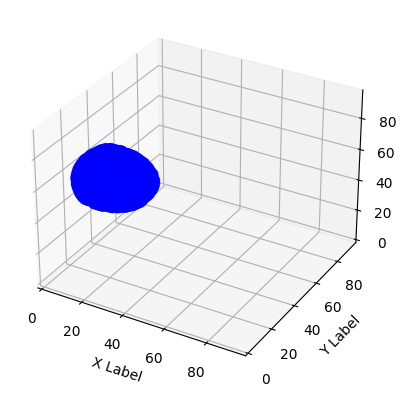

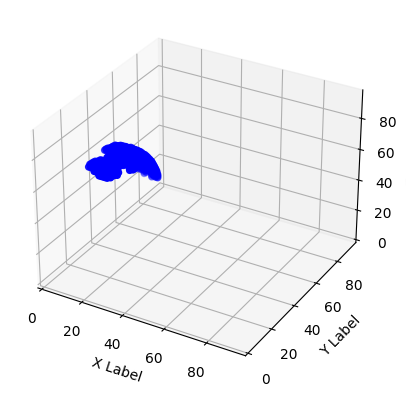

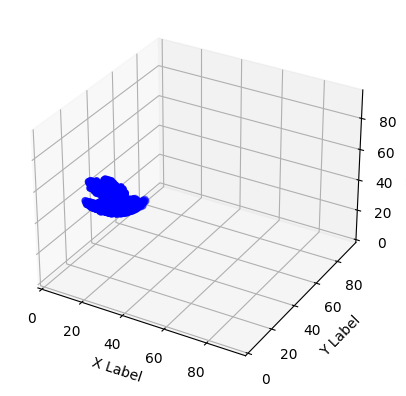

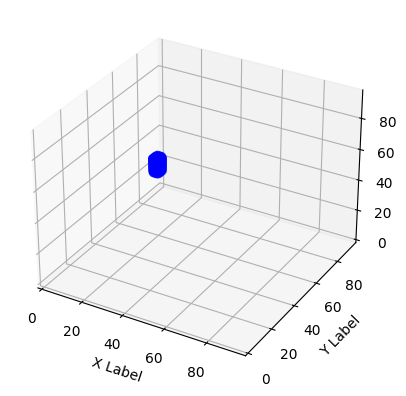

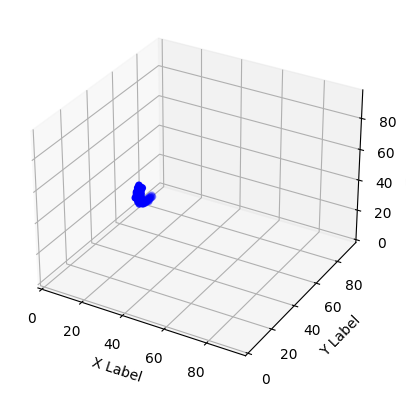

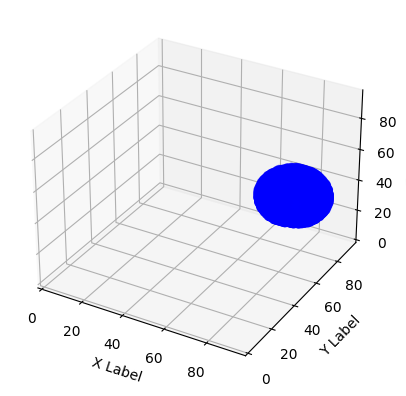

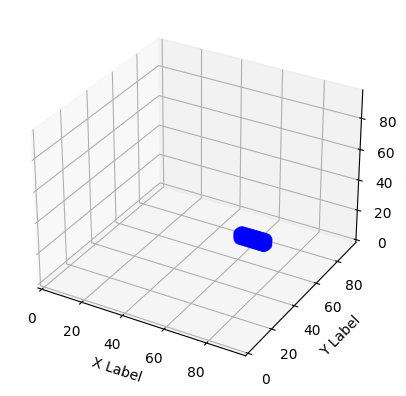

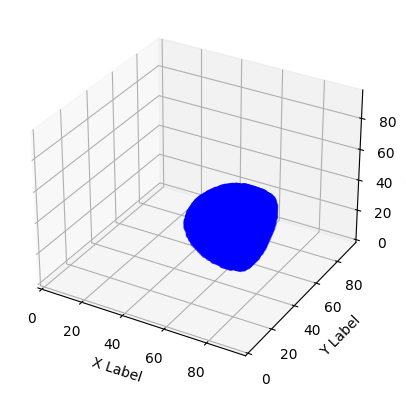

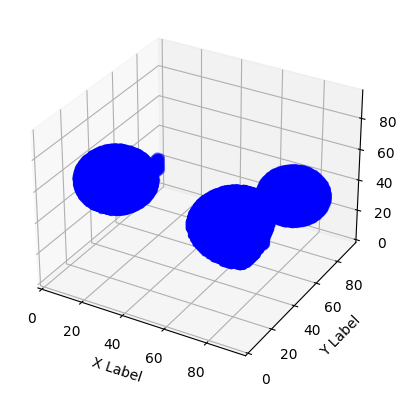

In [ ]:
#----Visualize all object masks, then the total mask with everything in it.----

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


calculateBigMask = False
bigMask = None
#This gets the full mask of all objects in the scene (any point that we detected something at will be 1, everything else 0)
#We can calculate it (we would in a real scenario), or not
if calculateBigMask:
  bigMask = np.zeros(allMasks[0].shape[:-1])
  for currMask in allMasks:
    for i in range(len(currMask)):
      for j in range(len(currMask[0])):
        for k in range(len(currMask[0][0])):
          if list(currMask[(i,j,k)]) != [0,0]:
            if bigMask[(i,j,k)] == 1:
              print("ALREADY 1", (i,j,k))
            bigMask[(i,j,k)] = 1

  np.save("/content/drive/MyDrive/bigMask", bigMask)
else:
  bigMask = maskTruth.copy()[0]
  bigMask = np.any(bigMask != [0,0], axis = 3)

finalMasks = []
for i in range(len(allMasks)):
  currMask = allMasks[i]
  finalMasks.append(np.any(currMask != [0,0], axis = 3))
finalMasks.append(bigMask)

for i in range(len(finalMasks)):

  # truthMask2 = np.any(bigMask != [0,0], axis = 3)
  truthMask2 = finalMasks[i].astype(bool)

  visualizing = truthMask2
  # Create a sample 3D array
  data = visualizing
  # Get the dimensions of the array
  x_dim, y_dim, z_dim = data.shape

  # Create a meshgrid for the x, y, and z dimensions
  x, y, z = np.meshgrid(np.arange(x_dim), np.arange(y_dim), np.arange(z_dim), indexing='ij')  # Use indexing='ij'

  # Create a mask to filter values equal to 1
  filtered_mask = truthMask2

  # Create a 3D plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the 3D array using scatter plot with filtered values
  ax.scatter(x[filtered_mask], y[filtered_mask], z[filtered_mask], c='b', marker='o')  # Use 'b' for blue color and 'o' for markers

  # Set labels for each axis
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  max_dim = max(x_dim, y_dim, z_dim)

  # Set limits to achieve equal scaling
  ax.set_xlim([0, max_dim])
  ax.set_ylim([0, max_dim])
  ax.set_zlim([0, max_dim])

  # Show the plot
  plt.show()
  # print("showing")


In [ ]:
#----Finally we have an array full of all masks----
np.array(finalMasks).shape

(9, 96, 96, 96)